In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))
from sklearn.metrics import mean_squared_error
from math import sqrt

from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

In [2]:
uber_raw_apr14 = pd.read_csv("Uber_Pickup_Dataset/uber-raw-data-apr14.csv")
uber_raw_may14 = pd.read_csv("Uber_Pickup_Dataset/uber-raw-data-may14.csv")
uber_raw_jun14 = pd.read_csv("Uber_Pickup_Dataset/uber-raw-data-jun14.csv")
uber_raw_jul14 = pd.read_csv("Uber_Pickup_Dataset/uber-raw-data-jul14.csv")
uber_raw_aug14 = pd.read_csv("Uber_Pickup_Dataset/uber-raw-data-aug14.csv")
uber_raw_sep14 = pd.read_csv("Uber_Pickup_Dataset/uber-raw-data-sep14.csv")

In [3]:
uber_2014 = [uber_raw_apr14, uber_raw_may14, uber_raw_jun14, uber_raw_jul14,uber_raw_aug14, uber_raw_sep14]

In [4]:
uber_2014

[                 Date/Time      Lat      Lon    Base
 0         4/1/2014 0:11:00  40.7690 -73.9549  B02512
 1         4/1/2014 0:17:00  40.7267 -74.0345  B02512
 2         4/1/2014 0:21:00  40.7316 -73.9873  B02512
 3         4/1/2014 0:28:00  40.7588 -73.9776  B02512
 4         4/1/2014 0:33:00  40.7594 -73.9722  B02512
 ...                    ...      ...      ...     ...
 564511  4/30/2014 23:22:00  40.7640 -73.9744  B02764
 564512  4/30/2014 23:26:00  40.7629 -73.9672  B02764
 564513  4/30/2014 23:31:00  40.7443 -73.9889  B02764
 564514  4/30/2014 23:32:00  40.6756 -73.9405  B02764
 564515  4/30/2014 23:48:00  40.6880 -73.9608  B02764
 
 [564516 rows x 4 columns],
                  Date/Time      Lat      Lon    Base
 0         5/1/2014 0:02:00  40.7521 -73.9914  B02512
 1         5/1/2014 0:06:00  40.6965 -73.9715  B02512
 2         5/1/2014 0:15:00  40.7464 -73.9838  B02512
 3         5/1/2014 0:17:00  40.7463 -74.0011  B02512
 4         5/1/2014 0:17:00  40.7594 -73.9734  B0251

In [5]:
uber_data_2014 = pd.concat(uber_2014,axis=0,ignore_index=True)

In [6]:
uber_data_2014.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [7]:
# uber_data_2014.Timestamp = pd.datetime(uber_data_2014['Date/Time'].format='%m/%d/%Y %H:%M:%S')
uber_data_2014.Timestamp = pd.to_datetime(uber_data_2014['Date/Time'],format='%m/%d/%Y %H:%M:%S')
uber_data_2014['Date_only'] = uber_data_2014.Timestamp.dt.date
uber_data_2014['Date'] = uber_data_2014.Timestamp
uber_data_2014['Month'] = uber_data_2014.Timestamp.dt.month
uber_data_2014['DayOfWeekNum'] = uber_data_2014.Timestamp.dt.dayofweek
uber_data_2014['DayOfWeek'] = uber_data_2014.Timestamp.dt.day_name()
uber_data_2014['MonthDayNum'] = uber_data_2014.Timestamp.dt.day
uber_data_2014['HourOfDay'] = uber_data_2014.Timestamp.dt.hour

# uber_data_2014= uber_data_2014.drop(columns = ['Lat','Lon'])
uber_data_2014.tail()

<ipython-input-7-e9ffbdb1139e>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  uber_data_2014.Timestamp = pd.to_datetime(uber_data_2014['Date/Time'],format='%m/%d/%Y %H:%M:%S')


,Date/Time,Lat,Lon,Base,Date_only,Date,Month,DayOfWeekNum,DayOfWeek,MonthDayNum,HourOfDay
4534322,9/30/2014 22:57:00,40.7668,-73.9845,B02764,2014-09-30,2014-09-30 22:57:00,9,1,Tuesday,30,22
4534323,9/30/2014 22:57:00,40.6911,-74.1773,B02764,2014-09-30,2014-09-30 22:57:00,9,1,Tuesday,30,22
4534324,9/30/2014 22:58:00,40.8519,-73.9319,B02764,2014-09-30,2014-09-30 22:58:00,9,1,Tuesday,30,22
4534325,9/30/2014 22:58:00,40.7081,-74.0066,B02764,2014-09-30,2014-09-30 22:58:00,9,1,Tuesday,30,22
4534326,9/30/2014 22:58:00,40.7140,-73.9496,B02764,2014-09-30,2014-09-30 22:58:00,9,1,Tuesday,30,22


In [8]:
import pandas_profiling
profile = pandas_profiling.ProfileReport(uber_data_2014)
profile

In [9]:
uber_data_2014.groupby('DayOfWeek').count()

,Date/Time,Lat,Lon,Base,Date_only,Date,Month,DayOfWeekNum,MonthDayNum,HourOfDay
DayOfWeek,,,,,,,,,,
Friday,741139,741139,741139,741139,741139,741139,741139,741139,741139,741139
Monday,541472,541472,541472,541472,541472,541472,541472,541472,541472,541472
Saturday,646114,646114,646114,646114,646114,646114,646114,646114,646114,646114
Sunday,490180,490180,490180,490180,490180,490180,490180,490180,490180,490180
Thursday,755145,755145,755145,755145,755145,755145,755145,755145,755145,755145
Tuesday,663789,663789,663789,663789,663789,663789,663789,663789,663789,663789
Wednesday,696488,696488,696488,696488,696488,696488,696488,696488,696488,696488


In [10]:
uber_data_2014.groupby(pd.Grouper(key='DayOfWeek')).count()

,Date/Time,Lat,Lon,Base,Date_only,Date,Month,DayOfWeekNum,MonthDayNum,HourOfDay
DayOfWeek,,,,,,,,,,
Tuesday,663789,663789,663789,663789,663789,663789,663789,663789,663789,663789
Wednesday,696488,696488,696488,696488,696488,696488,696488,696488,696488,696488
Thursday,755145,755145,755145,755145,755145,755145,755145,755145,755145,755145
Friday,741139,741139,741139,741139,741139,741139,741139,741139,741139,741139
Saturday,646114,646114,646114,646114,646114,646114,646114,646114,646114,646114
Sunday,490180,490180,490180,490180,490180,490180,490180,490180,490180,490180
Monday,541472,541472,541472,541472,541472,541472,541472,541472,541472,541472


In [11]:
uber_weekdays = uber_data_2014.pivot_table(index=['DayOfWeekNum','DayOfWeek'],values='Base',aggfunc='count')

In [12]:
uber_weekdays

,,Base
DayOfWeekNum,DayOfWeek,
0,Monday,541472
1,Tuesday,663789
2,Wednesday,696488
3,Thursday,755145
4,Friday,741139
5,Saturday,646114
6,Sunday,490180


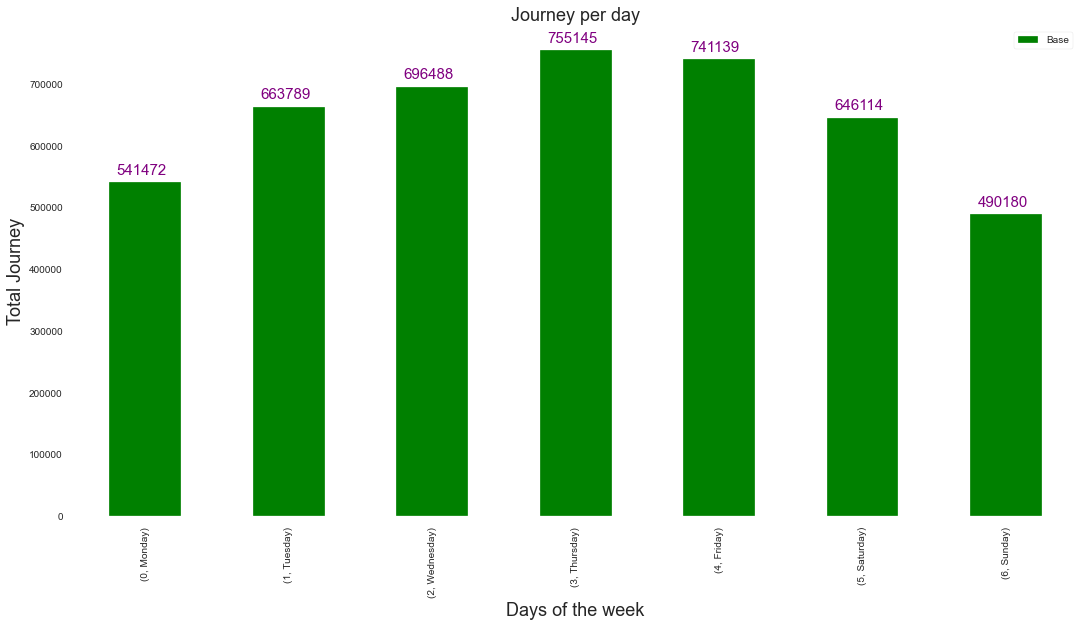

In [13]:
ax = uber_weekdays.plot(kind='bar', figsize=(18,9), color='green')
ax.set_ylabel("Total Journey", fontsize=18)
ax.set_xlabel("Days of the week", fontsize=18)
ax.set_title("Journey per day", fontsize=18)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)
# set individual bar lables using above list
# for i in ax.patches:
#     # get_x pulls left or right; get_height pushes up or down
#     ax.text(i.get_x()+.12, i.get_height()-3, \
#             str(round((i.get_height()/total)*100, 2))+'%',
#                 color='white',)
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.05, i.get_height()+12000, \
            str(round((i.get_height()), 2)), fontsize=15, color='purple',
                rotation=0)

<ipython-input-31-81c7e34d2eeb>:24: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(size, colors = colors, labels = labels, shadow = True, explode = explode, autopct = '%.2f%%')


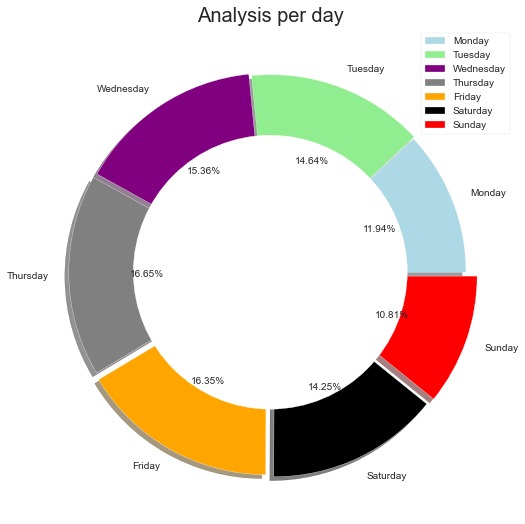

In [31]:
# size = data['sex'].value_counts()
# colors = ['lightblue', 'lightgreen']
# labels = "Male", "Female"
# # explode = [0, 0.01]

# my_circle = plt.Circle((0, 0), 0.7, color = 'white')

# plt.rcParams['figure.figsize'] = (9, 9)
# plt.pie(size, colors = colors, labels = labels, shadow = True, explode = explode, autopct = '%.2f%%')
# plt.title('Distribution of Gender', fontsize = 20)
# p = plt.gcf()
# p.gca().add_artist(my_circle)
# plt.legend()
# plt.show()

size = uber_weekdays
colors = ['lightblue', 'lightgreen','purple','grey','orange','black','red']
labels = "Monday", "Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"
explode = [0, 0.01,0.02,0.03,.04,.05,.06]

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, labels = labels, shadow = True, explode = explode, autopct = '%.2f%%')
plt.title('Analysis per day', fontsize = 20)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.legend()
plt.show()

In [32]:
uber_weekdays

,,Base
DayOfWeekNum,DayOfWeek,
0,Monday,541472
1,Tuesday,663789
2,Wednesday,696488
3,Thursday,755145
4,Friday,741139
5,Saturday,646114
6,Sunday,490180


In [14]:
uber_data_2014.groupby(pd.Grouper(key='HourOfDay')).count()

,Date/Time,Lat,Lon,Base,Date_only,Date,Month,DayOfWeekNum,DayOfWeek,MonthDayNum
HourOfDay,,,,,,,,,,
0,103836,103836,103836,103836,103836,103836,103836,103836,103836,103836
1,67227,67227,67227,67227,67227,67227,67227,67227,67227,67227
2,45865,45865,45865,45865,45865,45865,45865,45865,45865,45865
3,48287,48287,48287,48287,48287,48287,48287,48287,48287,48287
4,55230,55230,55230,55230,55230,55230,55230,55230,55230,55230
5,83939,83939,83939,83939,83939,83939,83939,83939,83939,83939
6,143213,143213,143213,143213,143213,143213,143213,143213,143213,143213
7,193094,193094,193094,193094,193094,193094,193094,193094,193094,193094
8,190504,190504,190504,190504,190504,190504,190504,190504,190504,190504


In [15]:
Uber_hour = uber_data_2014.pivot_table(index='HourOfDay',values='Base',aggfunc='count')

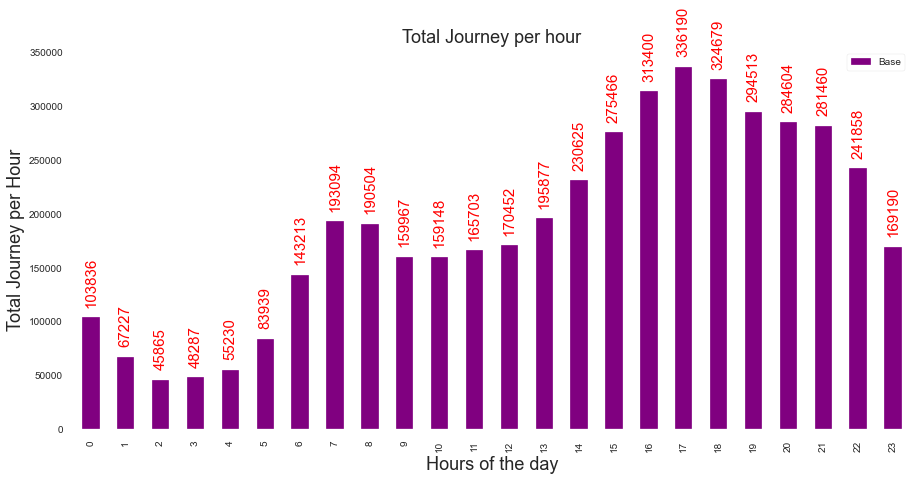

In [16]:
hrs = Uber_hour.plot(kind='bar',figsize=(15,7),color='purple')
hrs.set_ylabel("Total Journey per Hour", fontsize=18)
hrs.set_xlabel("Hours of the day", fontsize=18)
hrs.set_title("Total Journey per hour", fontsize=18)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in hrs.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)
# set individual bar lables using above list
# for i in ax.patches:
#     # get_x pulls left or right; get_height pushes up or down
#     ax.text(i.get_x()+.12, i.get_height()-3, \
#             str(round((i.get_height()/total)*100, 2))+'%',
#                 color='white',)
for i in hrs.patches:
    # get_x pulls left or right; get_height pushes up or down
    hrs.text(i.get_x()+.05, i.get_height()+12000, \
            str(round((i.get_height()), 2)), fontsize=15, color='red',
                rotation=90)

In [ ]:
size = data['sex'].value_counts()
colors = ['lightblue', 'lightgreen']
labels = "Male", "Female"
explode = [0, 0.01]

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, labels = labels, shadow = True, explode = explode, autopct = '%.2f%%')
plt.title('Distribution of Gender', fontsize = 20)
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.legend()
plt.show()

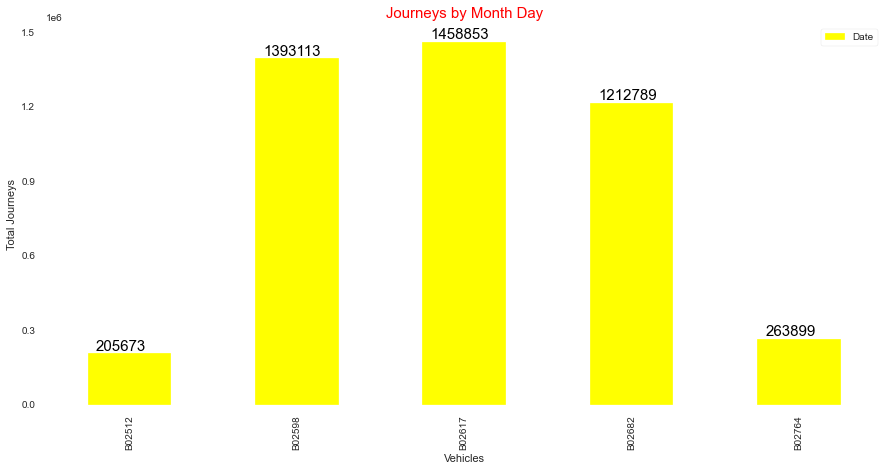

In [17]:
uber_data_2014.groupby(pd.Grouper(key='Base')).count()

uber_monthdays = uber_data_2014.pivot_table(index=['Base'], values='Date' ,
                                  aggfunc='count')
ht = uber_monthdays.plot(kind='bar',figsize=(15,7),color='yellow')
ht.set_yticks([0,300000,600000,900000,1200000,1500000])
plt.ylabel('Total Journeys')
plt.xlabel('Vehicles')
plt.title('Journeys by Month Day',fontsize='15',color='r');
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ht.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)
# set individual bar lables using above list
# for i in ax.patches:
#     # get_x pulls left or right; get_height pushes up or down
#     ax.text(i.get_x()+.12, i.get_height()-3, \
#             str(round((i.get_height()/total)*100, 2))+'%',
#                 color='white',)
for i in ht.patches:
    # get_x pulls left or right; get_height pushes up or down
    ht.text(i.get_x()+.05, i.get_height()+12000, \
            str(round((i.get_height()), 2)), fontsize=15, color='#000000',
                rotation=0)

In [18]:
uber_data_2014= uber_data_2014.drop(columns = ['Month','DayOfWeekNum','Base', 'DayOfWeek', 'MonthDayNum', 'HourOfDay'])

uber_count=uber_data_2014.groupby(pd.Grouper(key='Date')).count()
uber_count= uber_count.drop(columns = ['Date_only'])
print(uber_count.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260093 entries, 2014-04-01 00:11:00 to 2014-09-30 03:26:00
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Date/Time  260093 non-null  int64
 1   Lat        260093 non-null  int64
 2   Lon        260093 non-null  int64
dtypes: int64(3)
memory usage: 7.9 MB
None


In [19]:
uber_count.head()

,Date/Time,Lat,Lon
Date,,,
2014-04-01 00:11:00,6,6,6
2014-04-01 00:17:00,3,3,3
2014-04-01 00:21:00,5,5,5
2014-04-01 00:28:00,3,3,3
2014-04-01 00:33:00,5,5,5


In [20]:
train = uber_count[:][:234083]             #90% of 260093
test = uber_count[:][234084:]
display(train.tail())
test.head()



,Date/Time,Lat,Lon
Date,,,
2014-09-24 09:49:00,25,25,25
2014-09-24 09:50:00,16,16,16
2014-09-24 09:52:00,24,24,24
2014-09-24 09:56:00,15,15,15
2014-09-24 09:57:00,23,23,23


,Date/Time,Lat,Lon
Date,,,
2014-09-24 09:59:00,19,19,19
2014-09-24 10:00:00,15,15,15
2014-09-24 10:04:00,10,10,10
2014-09-24 10:05:00,17,17,17
2014-09-24 10:06:00,16,16,16


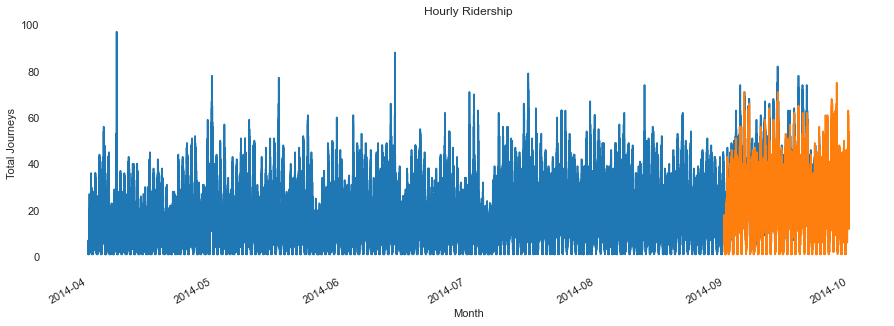

In [21]:
train['Date/Time'].plot(kind='line',figsize=(15,8), title= 'Hourly Ridership', fontsize=11)
test['Date/Time'].plot(figsize=(15,5), title= 'Hourly Ridership', fontsize=11)
plt.ylabel('Total Journeys')
plt.xlabel('Month')
plt.show()

In [22]:
uber_dates=uber_data_2014.groupby(pd.Grouper(key='Date_only')).count()
uber_dates= uber_dates.drop(columns = ['Date'])
print(uber_dates.info())
uber_dates_d= uber_dates.drop(columns = ['Date/Time'])

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 2014-04-01 to 2014-09-30
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Date/Time  183 non-null    int64
 1   Lat        183 non-null    int64
 2   Lon        183 non-null    int64
dtypes: int64(3)
memory usage: 5.7+ KB
None


In [23]:
train_ts = uber_dates[:][:163]                     #split is 90-10
test_ts = uber_dates[:][164:]
test_ts_d = uber_dates_d[:][164:]
test_ts.head()

,Date/Time,Lat,Lon
Date_only,,,
2014-09-12,39540,39540,39540
2014-09-13,43205,43205,43205
2014-09-14,28122,28122,28122
2014-09-15,29454,29454,29454
2014-09-16,36092,36092,36092


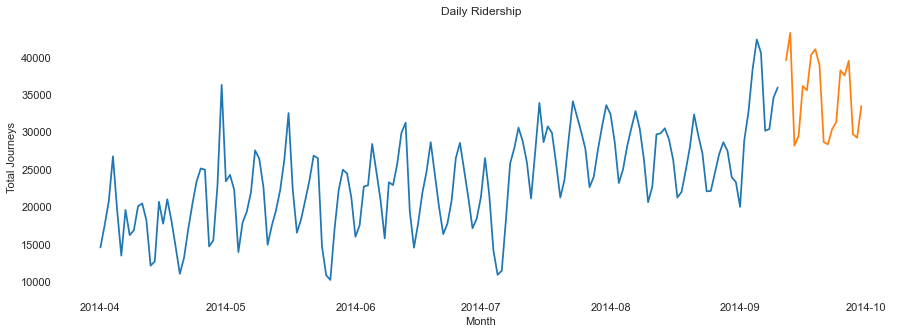

In [24]:
train_ts['Date/Time'].plot(kind='line',figsize=(15,8), title= 'Daily Ridership', fontsize=11)
test_ts['Date/Time'].plot(figsize=(15,5), title= 'Daily Ridership', fontsize=11)
plt.ylabel('Total Journeys')
plt.xlabel('Month')
plt.show()